In [7]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = [12, 5]

import time

In [8]:
#data importer class
#expects certain input format I should look that up

class earthquake_class():
    def __init__(self, csv_file_name, percentEarthquake, dt, step_size, amplitude_scaling):
        
        self.dt = dt
        self.step_size = step_size
        self.amplitude_scaling = amplitude_scaling
        
        #load file
        self.earthquake_data = []
        with open(csv_file_name, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                self.earthquake_data.append(row)
                
        #strip amplitude data
        amplitude = [value[1] for value in self.earthquake_data[9:]]
        
        self.amplitude = np.array(amplitude).astype('float')
        self.amplitude = self.amplitude[:int(percentEarthquake*self.amplitude.shape[0])]
        self.time = np.arange(0,self.dt*self.amplitude.shape[0],self.dt)
        
        self.dt_interpolated = None
        self.amplitude_interpolated = None
        self.time_interpolated = None
        
    def fit_spline(self):
        self.f = interpolate.interp1d(self.time, self.amplitude) #, kind='cubic')

    def interpolate_earthquake(self, time_stretch):
        self.dt_interpolated = self.dt / time_stretch
        self.time_interpolated = np.arange(0, self.time[-1], self.dt_interpolated)
        self.amplitude_interpolated = self.f(self.time_interpolated)
        self.time_interpolated *= time_stretch
        
    def calculate_steps(self):
        self.amplitude_interpolated_scaled = self.amplitude_interpolated * self.amplitude_scaling
        self.da = self.amplitude_interpolated_scaled[1:]-self.amplitude_interpolated_scaled[:-1]
        
        if np.abs(np.max(self.da)) > 1:
            print('Scaling constant or control frequency is too low')
            
            
        self.relativeSteps = np.zeros(self.amplitude_interpolated_scaled.shape[0])
        relativeStepsSum = 0
        for i in tqdm(range(self.amplitude_interpolated_scaled.shape[0])):
            if i > 0:
                relativeStepsSum += self.relativeSteps[i-1]
            if self.amplitude_interpolated_scaled[i] - relativeStepsSum >= 1:
                self.relativeSteps[i] = 1
            elif self.amplitude_interpolated_scaled[i] - relativeStepsSum <= -1:
                self.relativeSteps[i] = -1


In [45]:
earthquake = earthquake_class('earthquake.csv', percentEarthquake = 1, dt = 0.001, step_size = 2*np.pi/180/25, amplitude_scaling = 4)
earthquake.fit_spline()
earthquake.interpolate_earthquake(time_stretch = 50)
earthquake.calculate_steps()


  5%|▍         | 5780/119950 [00:00<00:01, 57793.85it/s]

Scaling constant or control frequency is too low


100%|██████████| 119950/119950 [00:02<00:00, 54653.28it/s]


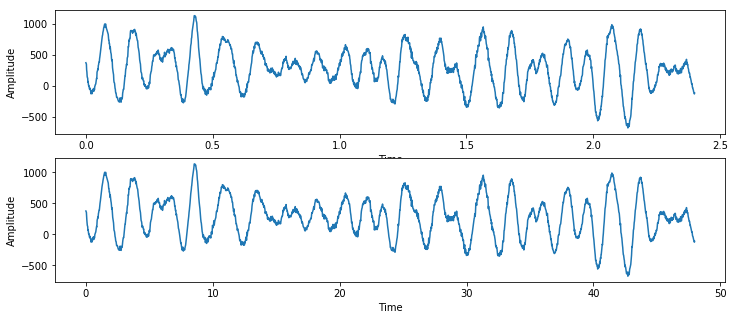

In [27]:

#print(earthquake.amplitude)
#print(earthquake.time)

plt.subplot(2,1,1)
plt.plot(earthquake.time, earthquake.amplitude)
plt.xlabel('Time')
plt.ylabel('Amplitude')



plt.subplot(2,1,2)
plt.plot(earthquake.time_interpolated, earthquake.amplitude_interpolated)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

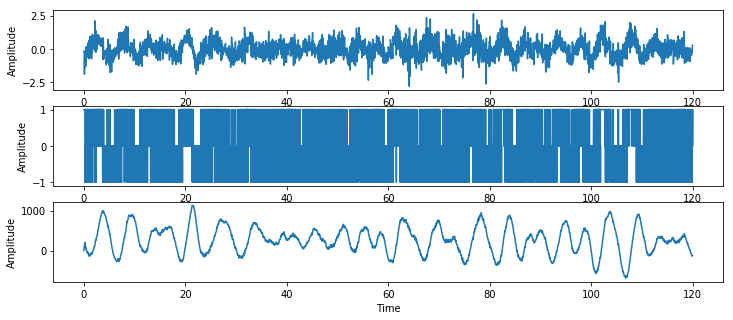

Number of time steps: 119950


In [35]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(earthquake.time_interpolated[:-1], earthquake.da)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(3,1,2)
plt.plot(earthquake.time_interpolated, earthquake.relativeSteps)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(3,1,3)
plt.plot(earthquake.time_interpolated, np.cumsum(earthquake.relativeSteps))
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

print('Number of time steps: {}'.format(earthquake.relativeSteps.shape[0]))

In [50]:
import RPi.GPIO as GPIO
import time
GPIO.setmode(GPIO.BCM)
control_pins = [17, 27]

dt = earthquake.dt/25

for pin in control_pins:
    GPIO.setup(pin, GPIO.OUT)
    GPIO.output(pin, 0)

seq1 = [
    [1,0],
    [0,0],
]

seq2 = [
    [1,1],
    [0,1],
]

A = earthquake.relativeSteps#np.hstack([np.ones(2000), np.ones(2000)*-1, np.ones(2000), np.ones(2000)*-1])
#A = yDelta

a = np.zeros(len(A))

for i in range(len(A)):
    start = time.time()
        
    val = A[i]
    
    if val == 1:
        for halfstep in range(2):
            GPIO.output(control_pins, seq1[halfstep])
    if val == -1:
        for halfstep in range(2):
            GPIO.output(control_pins, seq2[halfstep])
                
    while(time.time()-start<dt):
        wait = 1
        
    a[i] = (((time.time()-start)-dt)**2)**0.5

print(dt)
print(np.mean(a))
print(np.var(a))

GPIO.cleanup()

4e-05
4.7250555435187e-06
8.409426358182111e-11


In [32]:
dt

1e-05

use this to send the signals to the arduino to execute.


can we send the whole frame to the arduino in one go???


https://github.com/interactive-matter/MinProtocol

https://github.com/pootle/pisteppers

https://www.pjrc.com/store/teensy36.html

Try direct serial, then pistepper, then finally an exsternal micro

## Plot the loaded earthquake